# Experiment

## Prerequisites

Extract the data to:

In [4]:
METRICS_PATH<-"metrics/"

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog
- temps de deploiement vs nombre de fonctions
- la mémoire et le cpu au niveau du noeud fog

In [5]:
#install.packages('IRkernel') # Requires the tk package
#IRkernel::installspec()  # to register the kernel in the current R installation

In [6]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘formattable’


The following object is masked from ‘package:igraph’:

    normalize




Load the the Python `integration.py` script to use its variable in R

In [7]:
use_virtualenv('.venv/', required = TRUE)
import_from_path("monitoring", path = ".")

# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python('integration.py')) 

Module(monitoring)

Error in py_run_file_impl(file, local, convert) : SystemExit: 0



Load the graph network as an adjancency matrix

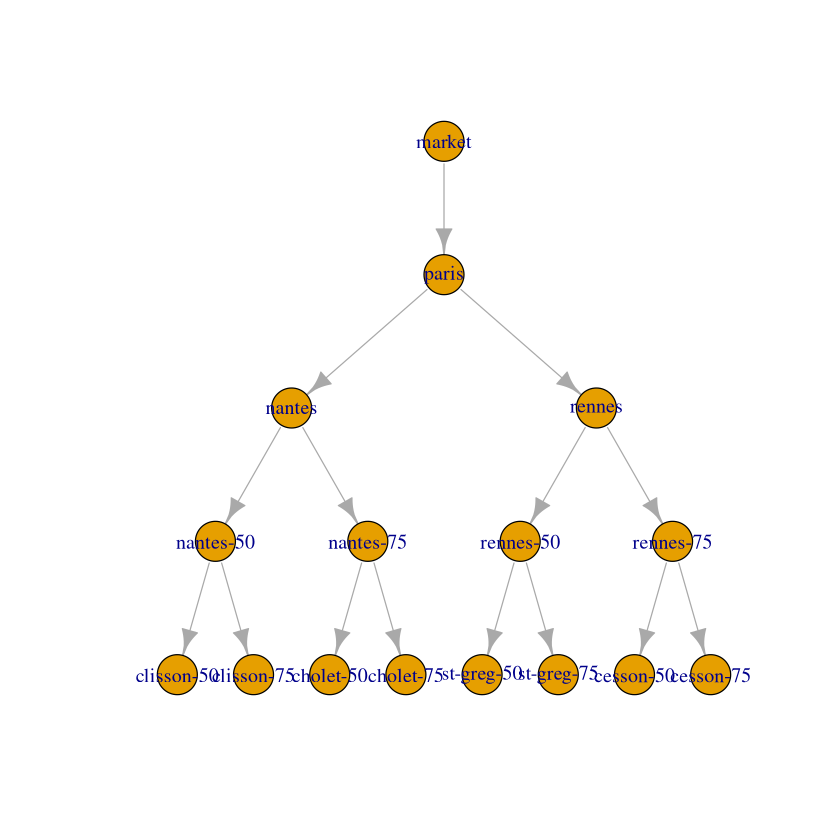

In [8]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret = matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }

  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout=layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)


## Data preprocessing

In [9]:
names_raw <- read.csv2(file = paste(METRICS_PATH,'names.csv',sep="/"), header = TRUE, sep = '\t')
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [10]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [11]:
mem <- read.csv2(file = paste(METRICS_PATH,'fog_node_memory_available.csv',sep="/"), header = TRUE, sep = '\t') %>%
    prepare %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    select(c(instance, value)) %>%
    mutate(dyn = formattable::percent(value / max(value, na.rm=TRUE))) %>%
    mutate(value = as.numeric(as.character(value)))

cpu <- read.csv2(file = paste(METRICS_PATH,'fog_node_cpu_used.csv', sep="/"), header = TRUE, sep = '\t') %>%
    prepare %>%
    select(c(instance, value)) %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    group_by(instance) %>%
    mutate(value = as.numeric(as.character(value)))


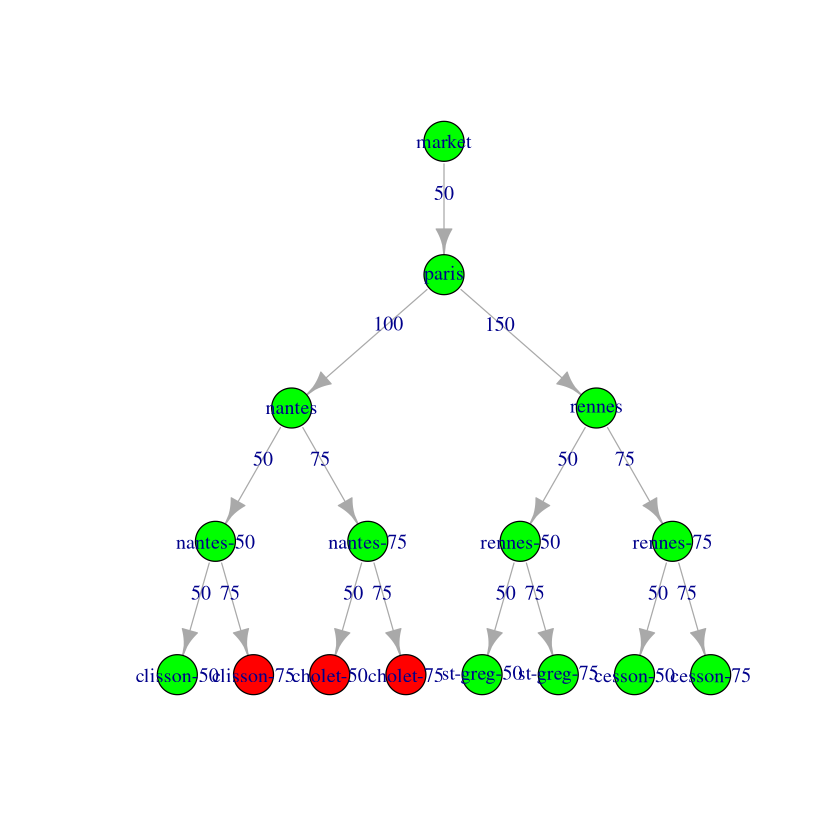

In [12]:
PercentageColourConnected <- function(x) { colorRampPalette(c('red', 'green'))(2)[ifelse(is.na(x), 1, 2)] }
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

Describe what nodes we have:
- size is the number of CPUs
- color is the RAM (purple is the max in the network)

Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”


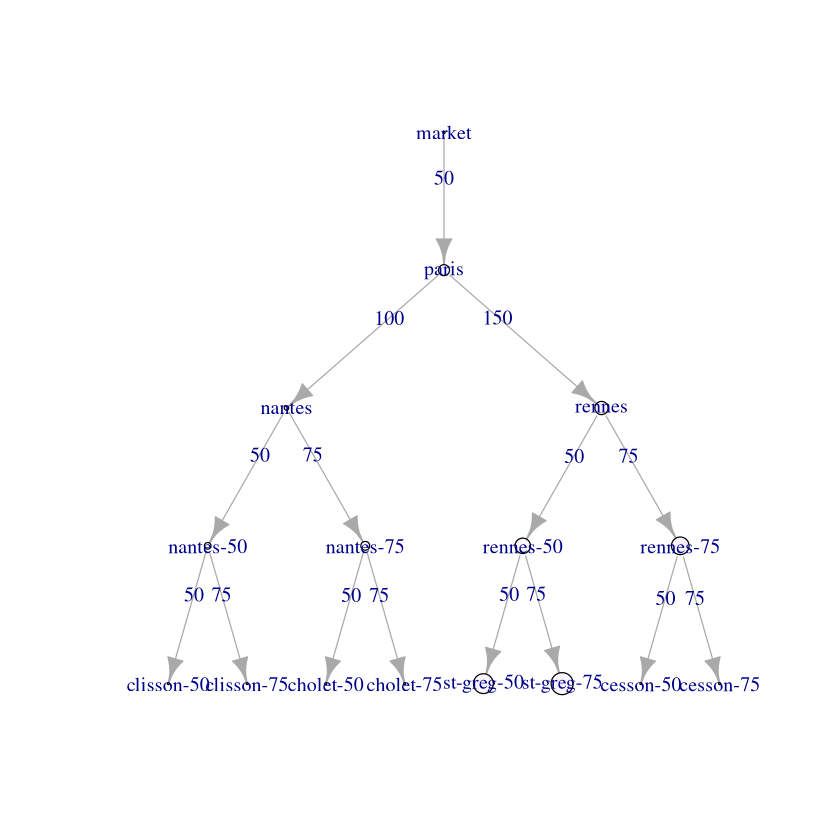

In [13]:
PercentageColour <- function(x){colorRampPalette(c('white','purple'))(101)[round(ifelse(is.na(x), 0, x)*100)+1]}
net_prez <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_prez)$size <- ifelse(is.na(cpu$value), 0, cpu$value * 8)
V(net_prez)$color <- PercentageColour(mem$dyn)
plot(net_prez, layout = layout_as_tree, edge.label = E(net_prez)$weight)

In [14]:
bids_raw <- read.csv2(file = paste(METRICS_PATH,'fog_node_bids.csv',sep="/"), header = TRUE, sep = '\t') %>%
prepare

head(bids_raw)

,instance,name,bid_id,function_name,job,timestamp,value,n
,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>
1,cesson-50,fog_node_bids,ac465f42-1bf8-4553-b197-968b7583b333,echo-007,telegraf,2022-07-28 13:47:55,0.1446427,0
2,cesson-50,fog_node_bids,d1f6f821-ad1c-4966-8476-81beac8b28e6,echo-090,telegraf,2022-07-28 13:52:45,0.1446427,0
3,cesson-50,fog_node_bids,c3b74f76-e722-4c03-b2e5-82b276725d5f,echo-043,telegraf,2022-07-28 13:47:50,0.1446427,0
4,cesson-50,fog_node_bids,4ce23370-2844-43cc-9512-2869d041806b,echo-020,telegraf,2022-07-28 13:49:20,0.1446427,0
5,cesson-50,fog_node_bids,55d4e625-bca3-40f3-901d-504183852db7,echo-016,telegraf,2022-07-28 13:44:35,0.1446427,0
6,cesson-50,fog_node_bids,c3b74f76-e722-4c03-b2e5-82b276725d5f,echo-043,telegraf,2022-07-28 13:47:45,0.1446427,0


instance,n
<chr>,<int>
market,98
rennes,2


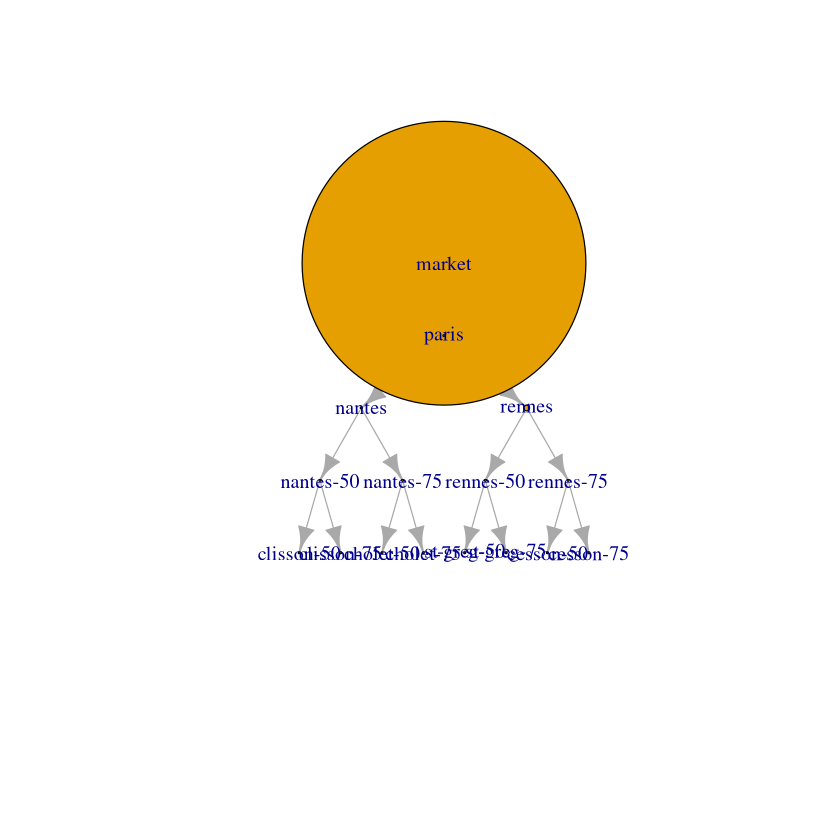

In [15]:
bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)


Plot the free memory

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


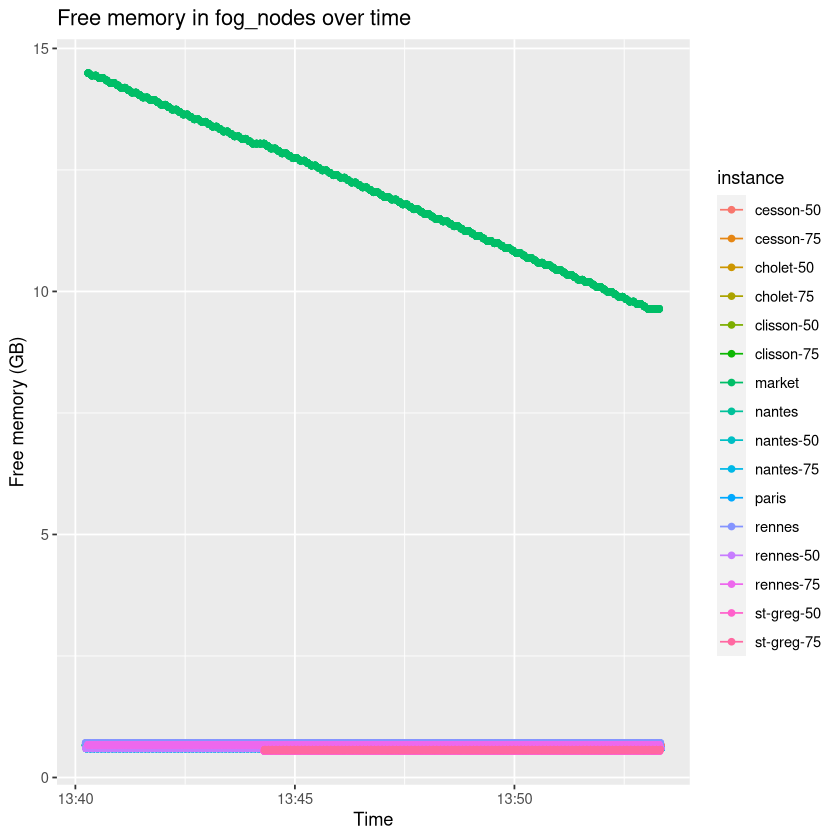

In [16]:
mem_used <- read.csv2(file = paste(METRICS_PATH,'fog_node_memory_used.csv', sep="/"), header = TRUE, sep = '\t') %>% prepare
mem_avail <- read.csv2(file = paste(METRICS_PATH,'fog_node_memory_available.csv', sep="/"), header = TRUE, sep = '\t') %>% prepare

mem_free <- mem_used %>%
        inner_join(mem_avail, by=c("instance", "timestamp")) %>%
        mutate(free = (value.y - value.x)/1e09) %>%
        select(instance, timestamp, free)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, color = instance)) +
  geom_step() +
  geom_point() +
  labs(x="Time", y="Free memory (GB)", title="Free memory in fog_nodes over time")

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

`summarise()` has grouped output by 'instance'. You can override using the
`.groups` argument.


instance,instance_to,mean_ms
<chr>,<chr>,<dbl>
cesson-50,rennes-75,101
cesson-75,rennes-75,151
cholet-50,nantes-75,101
cholet-75,nantes-75,151
clisson-50,nantes-50,100
clisson-75,nantes-50,150
market,paris,101
nantes,nantes-50,101
nantes,nantes-75,151


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



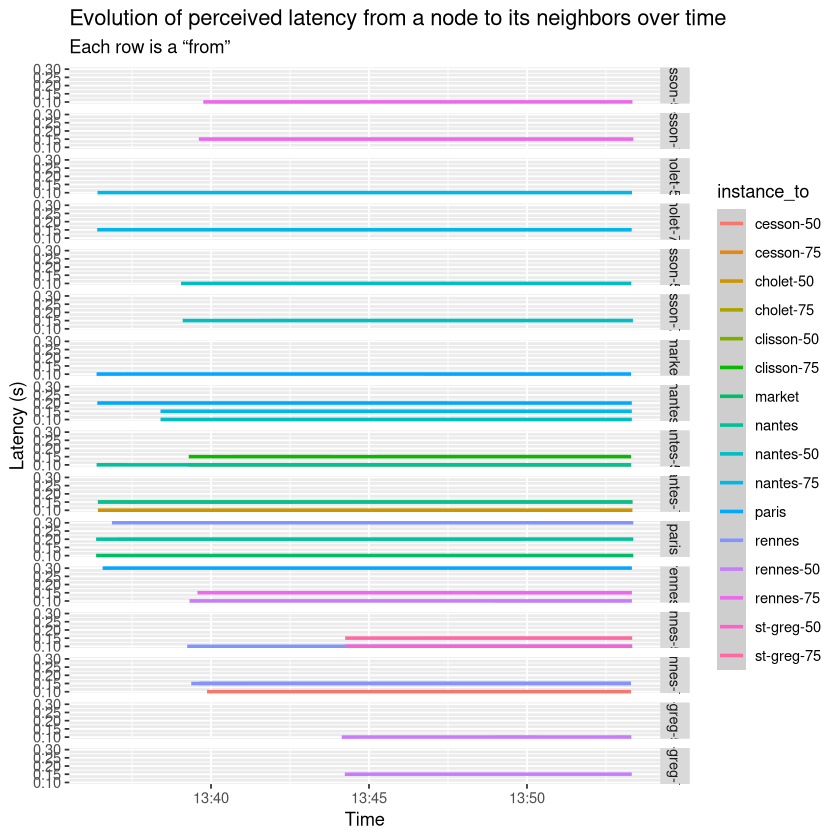

In [17]:
latency <- read.csv2(file = paste(METRICS_PATH,'fog_node_neighbors_latency_rolling_avg.csv',sep="/"), header = TRUE, sep = '\t') %>%
  prepare %>%
  mutate(instance_to = as.character(names[instance_to]))

latency %>%
  group_by(instance, instance_to) %>%
  summarise(mean_ms = round(mean(value*1000), 0))

latency %>%
  ggplot(aes(x = timestamp, y = value, color = instance_to)) +
  geom_smooth() +
  labs(x="Time", y="Latency (s)", title="Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
  facet_grid(rows = vars(instance))

In [18]:
bids_won_function <- read.csv2(file = paste(METRICS_PATH,'iot_emulation_http_request_duration_seconds_print_bucket.csv',sep="/"), header = TRUE, sep = '\t') %>%
  prepare %>%
  select(instance, tag, value, le, n)


In [19]:
head(bids_won_function)

,instance,tag,value,le,n
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,cesson-50,NA,NA,NA,0
2,cesson-75,NA,NA,NA,0
3,cholet-50,NA,NA,NA,0
4,cholet-75,NA,NA,NA,0
5,clisson-50,NA,NA,NA,0
6,clisson-75,NA,NA,NA,0


instance,name,bid_id,function_name,job,timestamp,value,n,winner
<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<dbl>,<chr>
market,fog_node_bids,cdfac7ba-826d-45b7-950a-2f22f136b01f,echo-001,telegraf,2022-07-28 13:49:47,0.001251265,0,market
market,fog_node_bids,c01f8d00-3edd-4e1f-855e-bea747533a73,echo-002,telegraf,2022-07-28 13:45:37,0.001262408,0,market
market,fog_node_bids,b9bcc119-ffc0-4aa3-a6c6-dba4df79e9ad,echo-003,telegraf,2022-07-28 13:52:37,0.001273769,0,market
market,fog_node_bids,fffd8751-2b37-4457-961f-59f6b424262c,echo-004,telegraf,2022-07-28 13:46:57,0.001285354,0,market
market,fog_node_bids,52c1df8d-e527-406d-b890-7856fe6da95e,echo-005,telegraf,2022-07-28 13:48:52,0.001297171,0,market
market,fog_node_bids,7eaf72f7-9943-4605-9f87-de531a74fbc0,echo-006,telegraf,2022-07-28 13:52:12,0.001309227,0,market


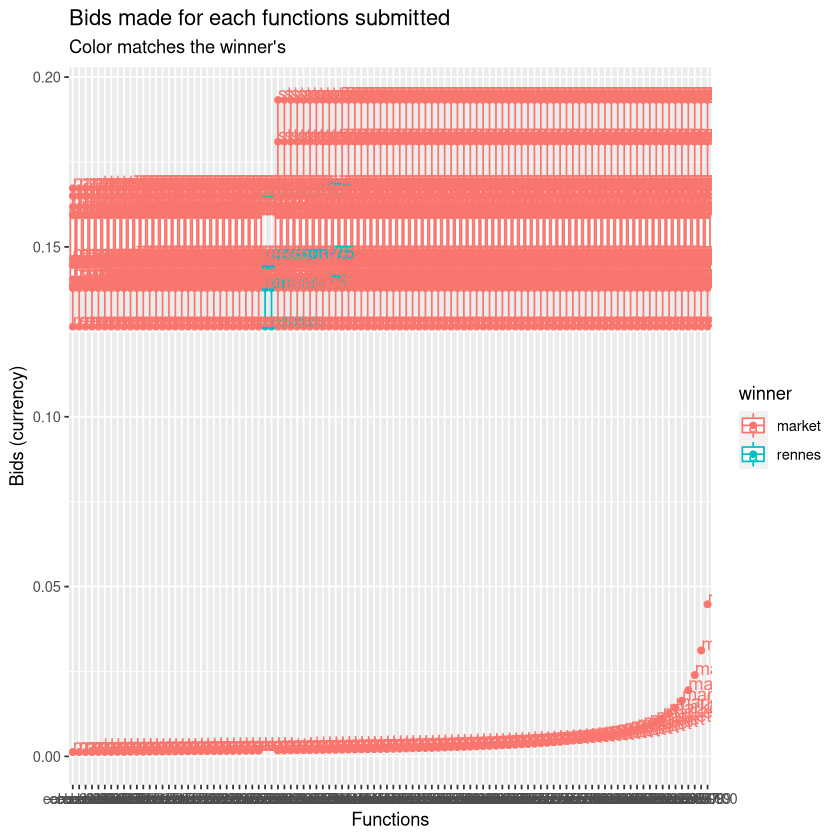

In [20]:
bids_won_function <- bids_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

head(bids_won_function)

bids_function <- bids_raw %>%
  select(c(instance, function_name, value)) %>%
  distinct() %>%
  inner_join(bids_won_function, by = c("function_name"))

bids_function %>%
  ggplot(aes(x = function_name, y = value.x, group = function_name, color = winner, label = instance.x)) +
  geom_boxplot() +
  geom_point() +
  geom_text(hjust = 0, vjust = 0) +
  labs(x="Functions", y="Bids (currency)", title="Bids made for each functions submitted", subtitle="Color matches the winner's")

timestamp,avg,tag,winner
<dttm>,<dbl>,<chr>,<chr>


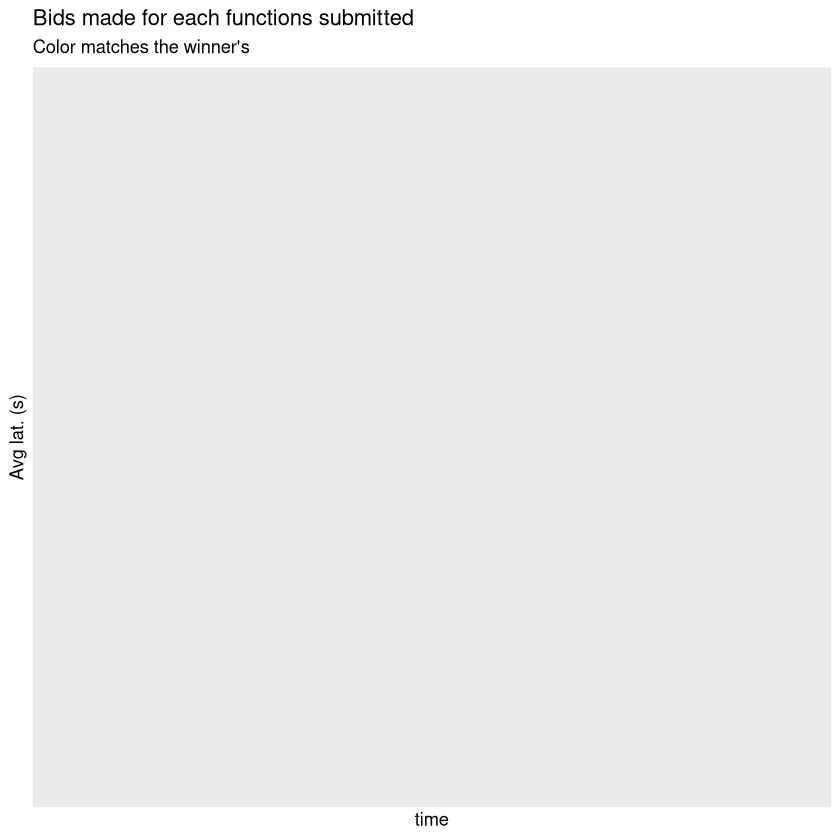

In [21]:
toto <- read.csv2(file = paste(METRICS_PATH,'iot_emulation_http_request_duration_seconds_print_sum.csv',sep="/"), header = TRUE, sep = '\t') %>%
  mutate(timestamp = as.numeric(as.character(timestamp))) %>%
  mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
  mutate(value = as.numeric(as.character(value)))


titi <- read.csv2(file = paste(METRICS_PATH,'iot_emulation_http_request_duration_seconds_print_count.csv',sep="/"), header = TRUE, sep = '\t') %>%
  mutate(timestamp = as.numeric(as.character(timestamp))) %>%
  mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
  mutate(value = as.numeric(as.character(value)))

tutu <- toto %>%
  inner_join(titi, by = c("instance", "job", "timestamp", "tag"), ) %>%
  mutate(avg = value.x/value.y) %>%
  select(timestamp, avg, tag) %>%
  filter(!is.na(avg)) %>%
  mutate(function_name=tag) %>%
  inner_join(bids_function %>% select(function_name, winner), by=c("function_name")) %>%
  select(timestamp, avg, tag, winner)

head(tutu)

tutu %>% 
  # ggplot(aes(x = timestamp, y = avg, group = tag, color = tag, label = tag)) +
  ggplot(aes(x=timestamp,y=avg)) +
  # geom_point() +
  geom_point(aes(color=winner), size=2, alpha = 0.5) +
  geom_density_2d_filled(alpha = 0.5) +
  geom_density_2d(size = 0.25, colour = "black") +
  # geom_bin_2d() +
  #geom_text(hjust = 0, vjust = 0) +
  labs(x="time", y="Avg lat. (s)", title="Bids made for each functions submitted", subtitle="Color matches the winner's")